## Introduction
In this notebook we will create a custom DataSet which will load and return an X-Ray image together with the location of the heart

## Imports:

* Path for easy path handling
* torch for dataset creation
* numpy for loading the images
* pandas for loading the csv file containing the labels
* imgaug to set a random seed for augmentations
* BoundingBox from imgaug to automatically handle the coordinates when augmenting the image



In [1]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox


/tmp/ipykernel_32829/3332615915.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## DataSet Creation
Now we define the torch dataset!
We need to define a __ len __ function which returns the length of the dataset and a __ getitem __ function which returns the image and corresponding bounding box.

Additionally we apply data augmentation and normalization.

**Important**: Augment bounding box together with image!<br />
You can use *BoundingBox(x1, y1, x2, y2) for that*.<br />
Next you call *self.augment(image=img, bounding_boxes=bb)* which returns the augmented image and bounding boxes<br />
Finally you extract the coordinates from the augmented bbox coordinates. Note that it is a 2D array.
```python
bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
```

In [2]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
        
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]


        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
            
        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
            
        return img, bbox


## Validate functionality

In [3]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [4]:
# First create the augmentation object

seq = iaa.Sequential([
            iaa.GammaContrast(),
            iaa.Affine(
                scale=(0.8, 1.2),
                rotate=(-10, 10),
                translate_px=(-10, 10)
            )
        ])


In [5]:
labels_path = "./rsna_heart_detection.csv"
patients_path = "train_subjects.npy"
train_root = "Processed-Heart-Detection/train/"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

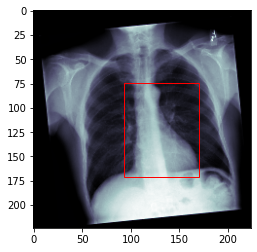

In [6]:
img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

tensor([ 68.0564,  52.9844, 160.1562, 162.0793])


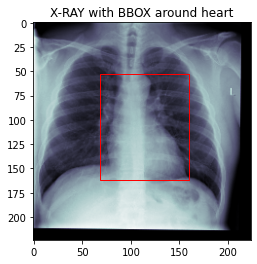

In [7]:
img, label = dataset[17]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)

Awesome! Now we can move to training the heart detection network